## QAOA Homework
### Quantum Computing FRI Stream Fall 2019

#### The aim of this project is to use your knowledge of quantum simulation and the quantum approximate optimization algorithm to solve an optimization problem. You will need to figure out how to represent your problem in quantum terms and then use your Hamiltonian to construct the state necessary for QAOA. Use an 8 qubit input space (8 vertices on the graph) and sample across the ranges of the parameters, $\gamma$ and $\beta$, in order to get an idea of where the cost function is the highest and lowest.

### 1. Choose and describe the problem you'd like to solve:
#### Max-Clique, Weighted Max-Cut, Weighted MAX-SAT, Weighted Graph Coloring, Ising Model

Given a graph with weighted edges, is there a subset S of vertices such that the edges connecting S and the complement of S have collective weight of at least W?

### 2. Cast the problem as an optimization problem.

Given a graph with weighted edges, find a subset S of the vertices such that the weight of the edges separating the two subsets is maximized!

### 3. Write out a general cost function for the problem. This can be the Hamiltonian for the system. 

$$C=\sum_{i,j} C_{i,j}$$

$$C_{i,j}=\frac{1}{2}({I-Z_{i}Z_{j}})$$

### 4. Use your cost function to construct a general constraint operator (called V in the lectures).

$$V(\gamma)=e^{-i\gamma\sum_{i,j} \frac{1}{2}(I-Z_{i}Z_{j})}$$

$$V(\gamma)=e^{-i\gamma C}$$
$$V(\gamma)=e^{-i\gamma\sum_{i,j} C_{i,j}}$$

# Implementation

In [1]:
#Import the necessary tools for the computation
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute,Aer
from qiskit import*
import random as r 
import numpy as np

### 5. Write a function to implement V and write a function to implement the driver, W, on your qubit system.

In [2]:
def H(q, qc):
    qc.h(q[1:])
    

In [3]:
def v(qc, q, edges, gamma):
    qc.barrier()
    for edge in edges:
        qc.cx(q[edge[1]], q[0])
        qc.cx(q[edge[0]], q[0])
        #multiply the gamma by the weights
        qc.u1(gamma * edge[2], q[0])
        qc.cx(q[edge[0]], q[0])
        qc.cx(q[edge[1]], q[0])
        qc.barrier()
   
        
         

In [4]:
def w(qc, q, beta):
     for i in range(1, len(q)):
        qc.h(i)
        qc.u1(beta, i)
        qc.h(i)
    

### 6. Prepare the parameters for your simulation.

#### This includes creating a grid of $\gamma$ and $\beta$ parameters. An example of such a grid is given in the assignment slide.

#### Think about how to generate your input space. You will need a graph with 8 vertices and a random assignment of edges. The graph should be connected more fully than a ring but less fully than all-to-all. The edges will determine which qubits you pair up when evaluating your cost function. Make sure to print out the list of edges, so there is a record of your particular graph.

#### You will also need to consider the values you will assign to your qubits. Depending on your choice of problem, you may want to handle the initialization differently. Figure this out now and, perhaps, prepare an array of values you will use in your qubit initialization in the next step.

In [5]:

   # for g_row in gamma:
    #    g in g_row:
     #   for beta in b_row:
      #      for b in beta:
    
#put this else wher when you make the circuit 
                

In [6]:
def edgy():
    edges=[]
    maxE = (8 *(8-1))//2
    numEdges = r.randint(8, maxE)
    counter =0
    i =1
    j= 2
    #assign a random weight (1, 10) to every combination of edges in a loop
    for pos in range(8):
        if i == 8:
            edges.append([1, i])   
        else:
            edges.append([i,j])
        i += 1
        j += 1
        counter += 1
    #while loop accounts for all the edges that are not in a closed loop and randomly generates them
    while counter != numEdges:
        weight = r.randint(1,10)
        i= r.randint(1, 8)
        j = r.randint(1, 8)
        edge=[i, j]
        edge.sort()
        
        if j != i and edge not in edges:
            edges.append(edge)
            counter  += 1
    edgesF= sorted(edges, key =lambda edge: edge[0])
    
    for edge in edgesF:
        weight = r.randint(1,10)
        edge.append(weight)
        
        
        
    return edgesF
            
        
    
        
    
        
        
    
    
    

In [7]:
def classicalV(bits, prob):
    count =0
    #50 is the number of shots
    prob = prob / 50
    for pos, i in enumerate(bits):
        while pos < len(bits):
            j = bits[pos]
        #the formula is 1/2(1-(-1)^i(-1)^j) where i and j are a comninations of 0,1 that maximizes the value
        #We do 2^n iterations to find all combinations that work
        #check to see if this is correct bc technically, you will check all combintations of (i,j) and (j,i); is this not double
        #counting?
            if i != j:
                count += 1
            pos+= 1
    return count * prob

            
            
            




### 7. Do the deed! Use your functions to prepare the state at each grid point. Use measurements to evaluate the cost function at each point. Keep track of these values. A loop may be helpful for streamlining your implementation.

### Your entire quantum circuit should be contained in this step.

In [8]:
gamma,beta = np.mgrid[0:2.1*np.pi:.2*np.pi,0:1.1*np.pi:.2*np.pi]
edges = edgy()
#print(edges)
#print(len(gamma))
#print(gamma)
#print(len(beta))
#print(beta)
allExVal=[]
gamma_list= [value for row in gamma for value in row]
beta_list= [value for row in beta for value in row]

for g_row, b_row in zip(gamma, beta):
    for g, b in zip(g_row, b_row):
        
        q = QuantumRegister(9)
        c = ClassicalRegister(9)
        qbits = [i for i in range(8)]
        qc = QuantumCircuit(q,c)
        H(q, qc)
        v(qc, q, edges, g)
        w(qc, q, b)
        qc.measure(q[1:], c[1:]) 
        #probability is the number of times you got that state divided by # of shots(2nd number in dict)
        #sum over every possibiliity of outcome times probability to get expected outcome; 
        #value of outcome is cost of state; cost of state is classically done by looking at every single egde; 
        #cost = outcome
        backend = Aer.get_backend('qasm_simulator')
        job = execute(qc, backend, shots=50)
        result = job.result()
        count=result.get_counts(qc)
        #counts.append(count)
        exVal = 0;
        for bits, prob in count.items():
            exVal += classicalV(bits, prob)
        allExVal.append(exVal)
print(allExVal)
        


        
        
     
            
            

        
        


[18.56, 17.959999999999997, 17.840000000000003, 18.399999999999995, 18.04, 18.599999999999998, 18.44, 17.959999999999997, 17.959999999999997, 17.439999999999998, 17.28, 18.2, 17.72, 18.280000000000005, 18.160000000000007, 16.92, 17.560000000000002, 18.08, 17.919999999999998, 17.680000000000003, 17.64, 17.240000000000002, 18.279999999999998, 17.04, 18.799999999999994, 16.999999999999996, 17.48, 17.52, 17.959999999999997, 17.800000000000004, 18.2, 18.199999999999996, 18.039999999999996, 18.12, 17.720000000000006, 18.599999999999998, 17.72, 17.919999999999995, 17.2, 17.520000000000003, 16.880000000000003, 17.960000000000004, 18.079999999999995, 18.599999999999998, 17.24, 16.92, 18.0, 17.919999999999998, 17.759999999999994, 17.159999999999997, 17.72, 17.479999999999997, 18.24, 17.560000000000002, 17.64, 17.599999999999998, 17.640000000000004, 16.760000000000005, 17.999999999999996, 18.159999999999997, 18.24, 17.839999999999996, 17.2, 18.119999999999997, 18.799999999999994, 18.3600000000000

### 8. Plot your results.
#### Creativity is welcome, but one option is a multidimensional histogram with the cost function as the height and the location dependent on the parameter grid.

Text(0.5, 0, 'Beta')

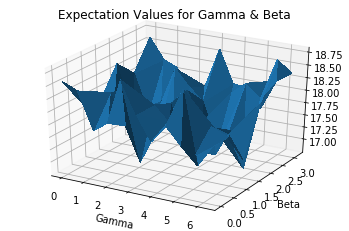

In [9]:
qc.draw() #uuhhhhh not sure about how to implement a histogram?

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

X=np.array(gamma_list)
Y=np.array(beta_list)
Z=np.array(allExVal)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=False)
ax.set_title('Expectation Values for Gamma & Beta')
ax.set_xlabel('Gamma')
ax.set_ylabel('Beta')

### 9. Comment on the process of converting your problem to the necessary form, implementing your functions, and interpreting your results. Finally, give your best approximation to the solution of your chosen problem.

Well, I guess I'll be able to get a certificate for this so thats nice. Do I understand anything? sort of? All I know for this project is that I looked at the picture on the power point and tried to find a pattern in the code to make it look like that for 8 quibits. prety easy. then I added some numbers for the beta\gamma. iterate through combinations of that. Im not really sure why this is useful, but at least im getting coding practice so yay! The results give me a graph of tons of expectation values. 

The classical/coding part I underdtand pretty well, like how to generate a random combination of the edges and not account for the repeats, how to iterate through the grid of beta/gammas, how to make comprehensive lists, how to apply the arthmetic for the quantum gates.

A solution? Well, the graph looks pointy, so Im going to go with the biggest point, which is like a 18.6 for my combo of shots/ weights.
